## histogram_map.ipynb

This notebook is meant to test whether the transformation I deviced in 11/27/17 can in principle make arbitrary initial histograms converge onto a desired histogram after repeated applications.

The transformation is the application of the weight kernel, so the discretized Frobenius-Perron equation will be:
\begin{equation}
\rho_{n+1}(r_k) = \sum_{i=1}^M \rho_n(r_i) \delta \left[ r_k - F \left( N \sum_{j=1}^N \omega_{ss}(r_i,r_j)r_j \rho_n(r_j) \right) \right]
\end{equation}  
where $\delta$ is the discrete delta function.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

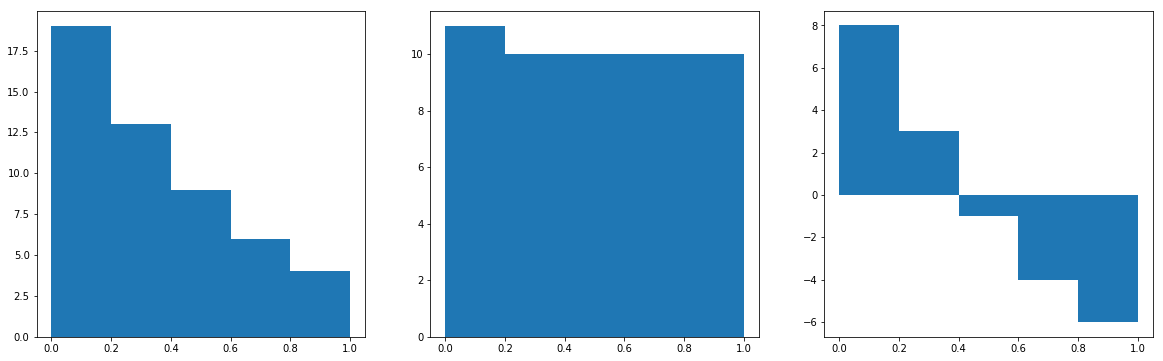

In [2]:
# Create the histograms
nbins = 5
n_units = 50 # more units than bins
x = np.linspace(0,1,nbins+1) # bin edges
wid = x[1]-x[0]  # width of bins
bin_edges = x # a name I can remember
bin_centers = ( x + (wid/2.) )[0:-1]

# the desired histogram has an exponential shape, parameter c
c = 2.
def exp_pdf(x):
    return ( c/(1.- np.exp(-c)) )* np.exp(-c*x)
exp_hist = np.array([int(round(wid*n_units*exp_pdf(x))) for x in bin_centers])
n_units = sum(exp_hist) # the discretization changes the number of units

# the initial histogram is random
def bin_number(x):
    return int( (x-1e-7) // wid )

rho = np.zeros(nbins)
while min(rho) < 1:
    for unit in range(n_units):
        rand_bin = bin_number(np.random.rand())
        rho[rand_bin] = rho[rand_bin] + 1
        
# the initial histogram is constant
per_bin = int(n_units//nbins)
remainder = n_units%nbins
rho = np.tile(per_bin, nbins)
rho[0] += remainder

#rho = exp_hist

hist_fig = plt.figure(figsize=(20,6))

exp_ax = hist_fig.add_subplot(1,3,1)
exp_ax.bar(bin_centers, exp_hist, wid, align='center')
init_ax = hist_fig.add_subplot(1,3,2)
init_ax.bar(bin_centers, rho, wid, align='center')
err_ax = hist_fig.add_subplot(1,3,3)
err_ax.bar(bin_centers, exp_hist-rho, wid, align='center')
plt.show()

In [9]:
# Initial definitions (matching math notation)
N = n_units
rho_n = rho / N
rho_d = exp_hist / N
r = bin_centers
M = nbins

def F(x):
    return 1./(1.+np.exp(-x))
    
def F_inv(x):
    return np.log(x/(1.-x))

u = F_inv(r)

q = [ 5.*(u[i+1]-u[i]) for i in range(M-1) ]
#q = 4.

def eq(a,b): # utility function to see if two 1-D arrays are equal
    for ai, bi in zip(a,b):
        if ai != bi:
            return False
    return True

def H(x): # The Heaviside step function
    return 0.5 * (np.sign(x) + 1.)

def w_ss0(i, j, mu, rho_n):
    return u[i]/(N*mu*rho_d[i])

def w_ss1(i, j, mu, rho_n): 
    """ The original weight kernel with 2-bin expansion. """
    if j == i-1 or j == i-2:
        clp_rho = max(1./N, rho_n[j])
        return u[i]/mu - q*abs(rho_d[j] - rho_n[j])/(N*r[j]*clp_rho)
    elif j == i+1 or j == i+2:
        clp_rho = max(1./N, rho_n[j])
        return u[i]/mu + q*abs(rho_d[j] - rho_n[j])/(N*r[j]*clp_rho)
    else:
        return u[i]/mu

def w_ss2(i, j, mu, rho_n):
    """ The original weight kernel with handling of endpoint rates. """
    if i == 0 or i == 1:
        if j == i:
            clp_rho = max(1./N, rho_n[j])
            return u[i]/mu + q*( 1./rho_d[j] - 1./rho_n[j] )/N
        else:
            return u[i]/mu
    elif i == M-1 or i == M-2:
        if j == i:
            clp_rho = max(1./N, rho_n[j])
            return u[i]/mu + q*(-1./rho_d[j] + 1./rho_n[j] )/N
        else:
            return u[i]/mu
    elif j == i-1 or j == i-2:
        clp_rho = max(1./N, rho_n[j])
        return u[i]/mu - q*abs(rho_d[j] - rho_n[j])/(N*r[j]*clp_rho)
    elif j == i+1 or j == i+2:
        clp_rho = max(1./N, rho_n[j])
        return u[i]/mu + q*abs(rho_d[j] - rho_n[j])/(N*r[j]*clp_rho)
    else:
        return u[i]/mu

def w_ss3(i, j, mu, rho_n):
    """ Weight kernel with handling of endpoint rates and control of own bin. """
    if i == 0 or i == 1:
        modif =  q*np.sign( rho_n[i] - rho_d[i] ) 
        return (u[i] + modif) / mu
    if i == M-1  or i == M-2:
        modif =  q*np.sign( rho_d[i] - rho_n[i] ) 
        return (u[i] + modif) / mu
    elif j == i-1 or j == i-2: 
        clp_rho = max(1./N, rho_n[j])
        return u[i]/mu - q*abs(rho_d[j] - rho_n[j])/(N*r[j]*clp_rho)
    elif j == i+1 or j == i+2:
        clp_rho = max(1./N, rho_n[j])
        return u[i]/mu + q*abs(rho_d[j] - rho_n[j])/(N*r[j]*clp_rho)
    elif j == i:
        clp_rho = max(1./N, rho_n[j])
        rndsgn = np.random.choice([-1.,1.],1)[0]
        return u[i]/mu + q*(rndsgn*1./rho_d[j] - rndsgn*1./clp_rho )/N
    else:
        return u[i]/mu

def w_ss4(i, j, mu, rho_n):
    """ A different kernel with handling of endpoint rates and control of own bin.
        In this one all increments/decrements are the same size. 
    """
    if i == 0 or i == 1:
        modif =  -q*np.sign( rho_n[i] - rho_d[i] ) 
        return (u[i] + modif) / mu
    if i == M-1  or i == M-2:
        modif =  q*np.sign( rho_d[i] - rho_n[i] ) 
        return (u[i] + modif) / mu
    elif j == i-1 or j == i-2: 
        clp_rho = max(1./N, rho_n[j])
        return u[i]/mu - q*abs(rho_d[j] - rho_n[j])/(N*r[j]*clp_rho)
    elif j == i+1 or j == i+2:
        clp_rho = max(1./N, rho_n[j])
        return u[i]/mu + q*abs(rho_d[j] - rho_n[j])/(N*r[j]*clp_rho)
    elif j == i:
        clp_rho = max(1./N, rho_n[j])
        rndsgn = np.random.choice([-1.,1.],1)[0]
        return u[i]/mu + q*(rndsgn*1./rho_d[j] - rndsgn*1./clp_rho )/N
    else:
        return u[i]/mu
    
def w_ss5(i, j, mu, rho_n):
    """ Weight kernel with control of own bin. """
    if j == i-1 or j == i-2:
        clp_rho = max(1./N, rho_n[j])
        return u[i]/mu - q*abs(rho_d[j] - rho_n[j])/(N*r[j]*clp_rho)
    elif j == i+1 or j == i+2:
        clp_rho = max(1./N, rho_n[j])
        return u[i]/mu + q*abs(rho_d[j] - rho_n[j])/(N*r[j]*clp_rho)
    elif j == i:
        clp_rho = max(1./N, rho_n[j])
        rndsgn = np.random.choice([-1.,1.],1)[0]
        return u[i]/mu + q*(rndsgn*1./rho_d[j] - rndsgn*1./clp_rho )/N
    else:
        return u[i]/mu
    
def w_ss6(i, j, mu, rho_n):
    """ Simplest approach. """
    modif =  q[min(M-2,i)]*np.sign( rho_d[i] - rho_n[i] )
    #if i == 0:
    #    modif = 5.*q[i]*max( np.sign(rho_n[i] - rho_d[i]), 0.)
    return (u[i] + modif) / mu

def w_ss7(i, j, mu, rho_n):
    """ Squashing in the appropriate direction. """
    if i > 1 and i < M-1:
        modif = 8.*q[i]*np.sign( ( (rho_n[i-1]-rho_d[i-1]) - (rho_n[i+1]-rho_d[i+1]) )*max((rho_n[i]-rho_d[i]), 0.) )
    #elif i == 0:
    #    modif = q*np.sign(max((rho_n[i]-rho_d[i]), 0.))
    #elif i == M-1:
    #    modif = -q*np.sign(max((rho_n[i]-rho_d[i]), 0.))
    else:
        modif = 0.
    return (u[i] + modif)/mu

def w_ss8(i, j, mu, rho_n):
    """ Diffusion of density difference. """
    E = rho_d - rho_n
    if i > 0 and i < M-1:
        modif = q[i]*np.sign( 0.5*( E[i-1]+E[i+1] ) - E[i] )
    elif i == 0:
        modif = q[i]*np.sign( E[i+1] - E[i] )
    elif i == M-1:
        modif = q[i-1]*np.sign( E[M-1] - E[M-2] )
    return (u[i] + modif)/mu

def w_ss9(i, j, mu, rho_n):
    """ Diffusion in the appropriate direction. """
    E = rho_d - rho_n
    if i > 0 and i < M-1:
        comp =  0.5*( E[i-1]+E[i+1] ) - E[i] 
        modif = q[i] * np.sign( ( E[i+1]-E[i-1] ) * max(comp,0.) )
    elif i == 0:
        comp = E[i+1] - E[i]
        modif = q[i]*np.sign( max(comp,0) ) #H(comp)
    elif i == M-1:
        comp = E[M-2] - E[M-1]
        modif = q[i-1]*np.sign( max(comp,0))
    return (u[i] + modif)/mu

def w_ss10(i, j, mu, rho_n):
    """ Diffusion of units along the error gradient. """
    E = rho_d - rho_n
    clp_rho = max(1./N, rho_n[j])
    if i > 0 and i < M-1:
        if j == i-1:
            modif = q[i]*H(E[i] - E[j])/(2*N*r[j]*clp_rho)
        elif j == i+1:
            modif = q[i]*H(E[j] - E[i])/(2*N*r[j]*clp_rho)
        elif j == i:
            comp =  0.5*( E[i-1]+E[i+1] ) - E[i] 
            modif = q[i] * np.sign( ( E[i+1]-E[i-1] ) * comp ) / (N*r[j]*clp_rho)
        else:
            modif = 0.
    elif i == 0:
        if j == i:
            comp = E[i+1] - E[i]
            modif = q[i]*H(comp) / (N*r[j]*clp_rho)
        else:
            modif = 0.
    elif i == M-1:
        if j == i:
            comp = E[M-2] - E[M-1]
            modif = -q[i-1]*H(comp) /(N*r[j]*clp_rho)
        else:
            modif = 0.
    return (u[i]/mu) + modif

In [10]:
# Iterating
from IPython.core.debugger import set_trace

def iterator(N, rho_n, rho_d, r, M, F, F_inv, w_ss, u, bin_number, n_iters=1):

    all_rho = np.zeros((n_iters+1,M))
    all_rho[0,:] = rho_n
    new_rho = np.zeros(M)
    rwid = r[1]-r[0]
    set_trace()
    for itr in range(n_iters):
        mu = sum(N * rho_n * r)
        new_count = np.zeros(M)
    
        for rate in range(M):
            tot_input = N * sum([w_ss(rate, j, mu, rho_n)*r[j]*rho_n[j] for j in range(M)])
            act = F(tot_input)
            # instead of transfering all units from one bit to the other, we'll just move some
            in_bin = int(round(rho_n[rate]*N))
            #trans = int(np.ceil(0.1*np.random.rand()*in_bin))
            trans = 1 # int(np.ceil(.2*in_bin))
            left = in_bin - trans
            
            # "normal" way of setting rec_bin
            #rec_bin = bin_number(act)
            
            # "gradual" way of setting rec_bin
            if act > r[rate] + rwid/4.:
                rec_bin = min(rate+1, M-1)
            elif act < r[rate] - rwid/4.:
                rec_bin = max(rate-1, 0)
            else:
                rec_bin = rate
                
            new_count[rec_bin] = new_count[rec_bin] + trans
            new_count[rate] += left
            """
            if bin_number(act) == 0:
                print("rate %d sending %d units to %d" % (rate,trans,0))
            elif bin_number(act) == M-1:
                print("rate %d sending %d units to %d" % (rate,trans,M-1))
            if rate == M-1:
                print("(: :) (: :) (: :) (: :) (: :) (: :) (: :) (: :)")
            """
            if abs(rec_bin - rate) > 1:
                print("transfer from %d to %d" % (rate, bin_number(act)))
                
        mu = sum(new_count * r)
        rho_n = new_count / N
    
        #print("this should be 1: %f" % (sum(rho_n)))
        all_rho[itr+1,:] = rho_n
        if eq(all_rho[itr,:], all_rho[itr+1,:]):
            print("Distribution converged at iteration %d" % (itr))
    return all_rho

> <ipython-input-10-006b039278de>(11)iterator()
      9     rwid = r[1]-r[0]
     10     set_trace()
---> 11     for itr in range(n_iters):
     12         mu = sum(N * rho_n * r)
     13         new_count = np.zeros(M)

ipdb> c
Distribution converged at iteration 6
Distribution converged at iteration 7
Distribution converged at iteration 8
Distribution converged at iteration 9
Distribution converged at iteration 10
Distribution converged at iteration 11
Distribution converged at iteration 12
Distribution converged at iteration 13
Distribution converged at iteration 14
Distribution converged at iteration 15
Distribution converged at iteration 16
Distribution converged at iteration 17
Distribution converged at iteration 18
Distribution converged at iteration 19
Distribution converged at iteration 20
Distribution converged at iteration 21
Distribution converged at iteration 22
Distribution converged at iteration 23
Distribution converged at iteration 24


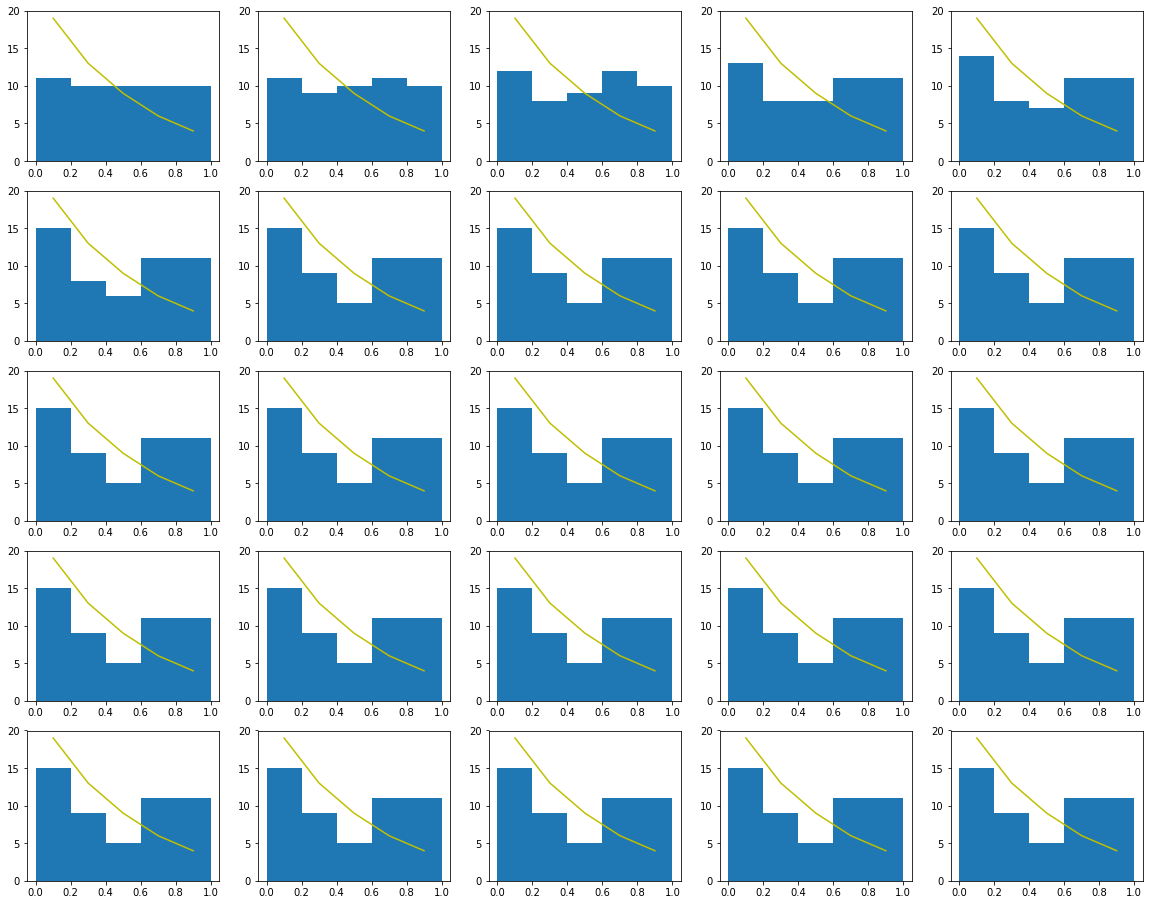

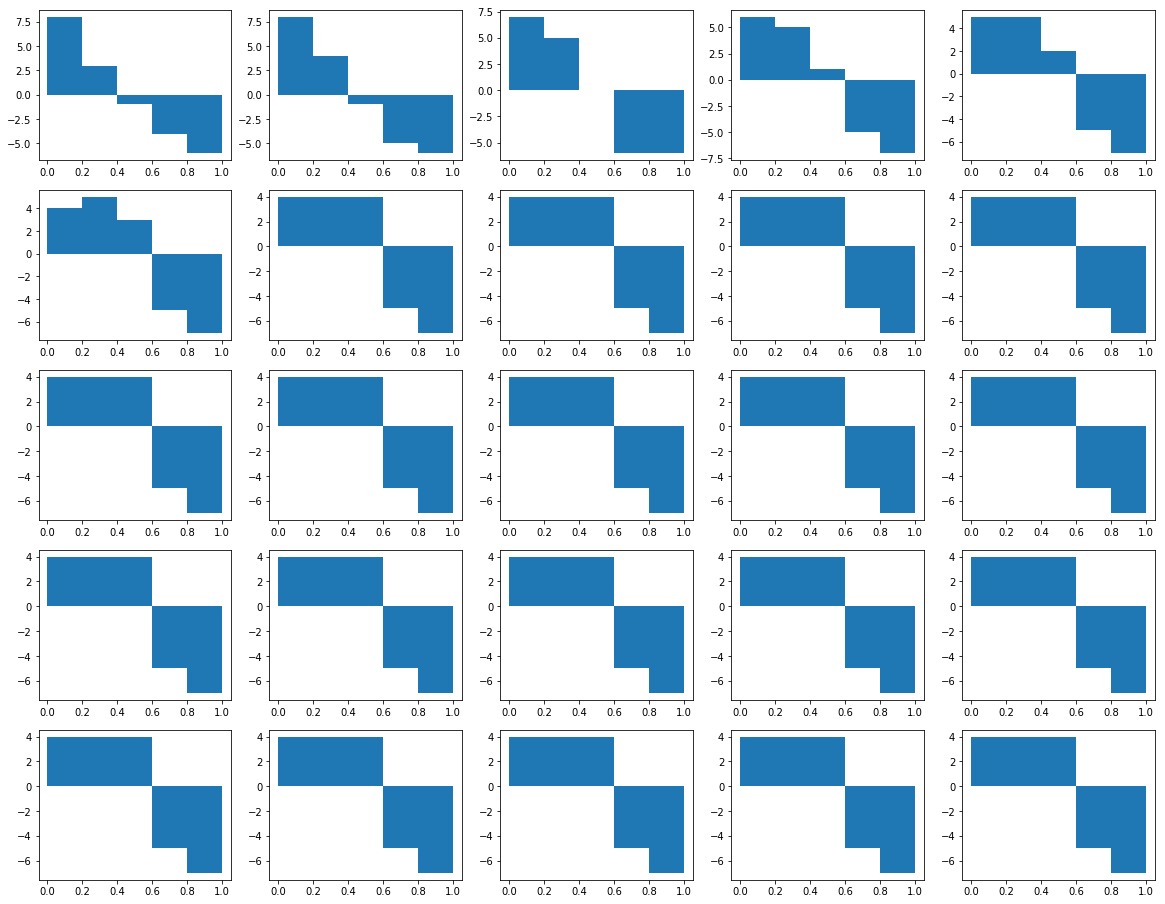

In [11]:
iters = 25
all_rho = iterator(N, rho_n, rho_d, r, M, F, F_inv, w_ss8, u, bin_number, n_iters=iters)
end_fig = plt.figure(figsize=(20,16))
jump = int(np.floor(iters/25))
for i in range(25):
    ax = end_fig.add_subplot(5,5,i+1)
    ax.bar(bin_centers, N*all_rho[i*jump,:], wid, align='center')
    ax.plot(r, N*rho_d, 'y')
    
err_fig = plt.figure(figsize=(20,16))
jump = int(np.floor(iters/25))
for i in range(25):
    ax = err_fig.add_subplot(5,5,i+1)
    ax.bar(bin_centers, N*(rho_d - all_rho[i*jump,:]), wid, align='center')
plt.show()

[ 4.  4.  4. -5. -7.]


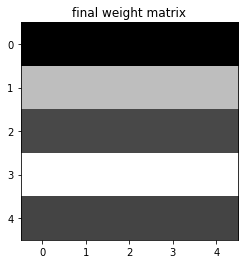

[[-0.36818346 -0.36818346 -0.36818346 -0.36818346 -0.36818346]
 [ 0.1394729   0.1394729   0.1394729   0.1394729   0.1394729 ]
 [-0.17434112 -0.17434112 -0.17434112 -0.17434112 -0.17434112]
 [ 0.31263092  0.31263092  0.31263092  0.31263092  0.31263092]
 [-0.18734193 -0.18734193 -0.18734193 -0.18734193 -0.18734193]]


In [26]:
print(n_units*(rho_d - all_rho[-1,:]))
rho = all_rho[-1,:]
mu = sum(N * rho * r)
w_mat = np.zeros((nbins, nbins))
for i in range(nbins):
    for j in range(nbins):
        w_mat[i,j] = w_ss8(i,j,mu,rho)
wfig, wax = plt.subplots()
wax.imshow(w_mat, cmap=plt.cm.gray, interpolation='nearest')
wax.set_title('final weight matrix')
plt.show()
print(w_mat)

Distribution converged at iteration 9
Distribution converged at iteration 10
Distribution converged at iteration 11
Distribution converged at iteration 12
Distribution converged at iteration 13
Distribution converged at iteration 14
Distribution converged at iteration 15
Distribution converged at iteration 16
Distribution converged at iteration 17
Distribution converged at iteration 18
Distribution converged at iteration 19
Distribution converged at iteration 20
Distribution converged at iteration 21
Distribution converged at iteration 22
Distribution converged at iteration 23
Distribution converged at iteration 24


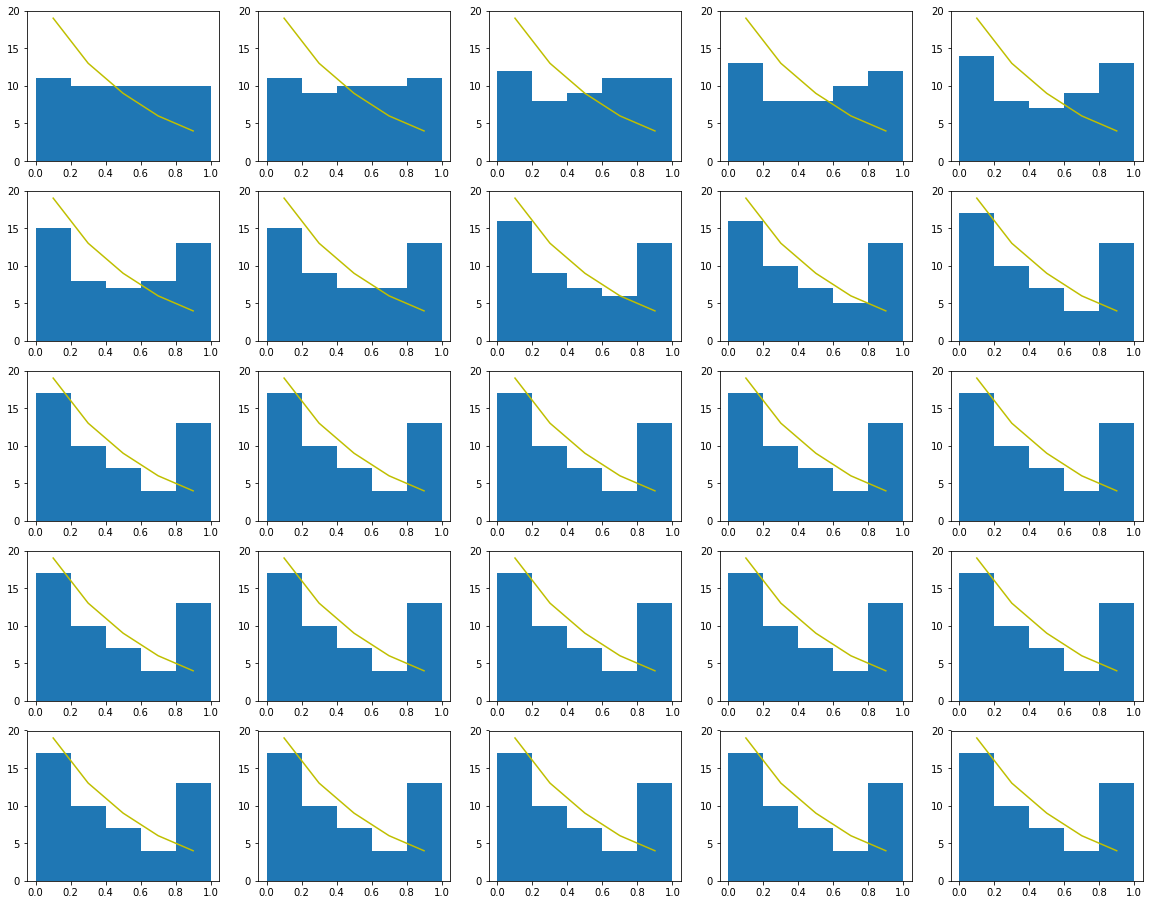

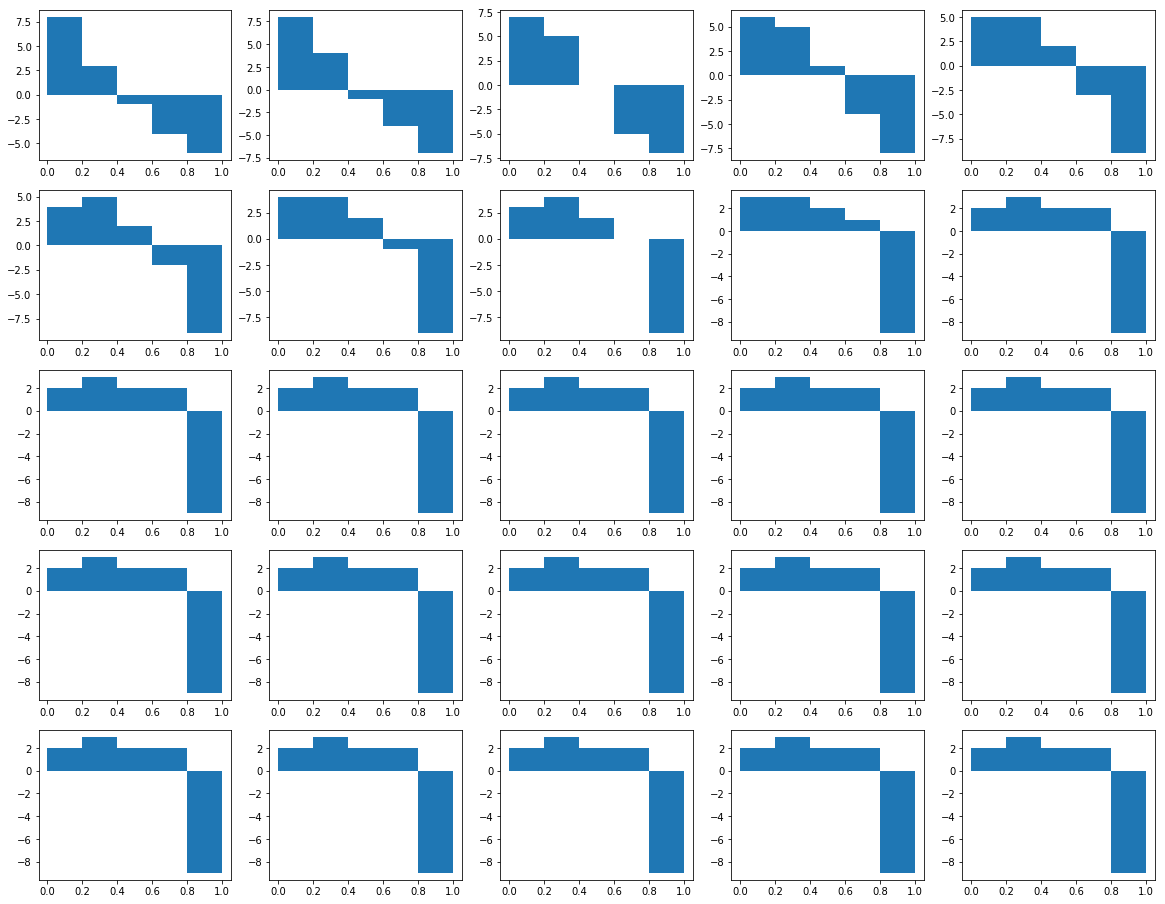

In [6]:
iters = 25
all_rho = iterator(N, rho_n, rho_d, r, M, F, F_inv, w_ss8, u, bin_number, n_iters=iters)
end_fig = plt.figure(figsize=(20,16))
jump = int(np.floor(iters/25))
for i in range(25):
    ax = end_fig.add_subplot(5,5,i+1)
    ax.bar(bin_centers, N*all_rho[i*jump,:], wid, align='center')
    ax.plot(r, N*rho_d, 'y')
    
err_fig = plt.figure(figsize=(20,16))
jump = int(np.floor(iters/25))
for i in range(25):
    ax = err_fig.add_subplot(5,5,i+1)
    ax.bar(bin_centers, N*(rho_d - all_rho[i*jump,:]), wid, align='center')
plt.show()

In [ ]:
%debug